In [20]:
from JupyterImport import *
from src.DatObject.Attributes import Transition as T, DatAttribute as DA
from scipy.stats import sem
FitInfo = DA.FitInfo
root_logger.setLevel(logging.WARNING)

In [21]:
dats = get_dats((7575, 7589+1))  #  300 -> base temp in 14 steps
dats.extend(get_dats((7684, 7689+1)))  # 100 -> 125mK in 5mK steps

100% (15 of 15) |########################| Elapsed Time: 0:00:00 Time:  0:00:00
100% (6 of 6) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00


In [24]:
ds = dats
ddict = {d.Logs.temps.mc: d for d in ds}
ds = [ddict[k] for k in sorted(ddict)]

infos = list()
for dat in progressbar(ds):
    infos.append(EA.calculate_careful_fit(dat, thresh = 1, param='theta'))

N/A% (0 of 21) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
 95% (20 of 21) |######################  | Elapsed Time: 0:00:31 ETA:   0:00:00WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (21 of 21) |########################| Elapsed Time: 0:00:32 Time:  0:00:32


In [4]:
width = 2000
fit_func = T.i_sense

def calc_new_fit(dat:DatHDF):
    x = dat.Transition.x
    idxs = CU.get_data_index(x, [-width, width])
    datas = dat.Transition.data[:, idxs[0]:idxs[1]]
    x = x[idxs[0]:idxs[1]]
    fs = T.transition_fits(x, datas, func=fit_func, auto_bin=True)
    if fs and None not in fs:
        all_fits = list()
        for f in fs:
            fi = FitInfo()
            fi.init_from_fit(f)
            all_fits.append(fi)
#         print(all_fits[0].best_values.theta)
        dat.Transition.all_fits = all_fits
        dat.Transition.set_avg_data()
        data = dat.Transition.avg_data[idxs[0]:idxs[1]]
        f = T.transition_fits(x, data, func=fit_func, auto_bin=True)[0]
        fit = FitInfo()
        fit.init_from_fit(f)
        dat.Other.trans_fit = fit
        dat.Other.update_HDF()
    else:
        dat.Other.trans_fit = None

recalculate = False
for dat in progressbar(dats):
    if not hasattr(dat.Other, 'trans_fit') or dat.Other.trans_fit is None or recalculate is True:
        calc_new_fit(dat)

N/A% (0 of 21) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--WARNING:src.DatObject.Attributes.Transition:LinAlgError encountered, retrying
100% (21 of 21) |########################| Elapsed Time: 0:03:51 Time:  0:03:51


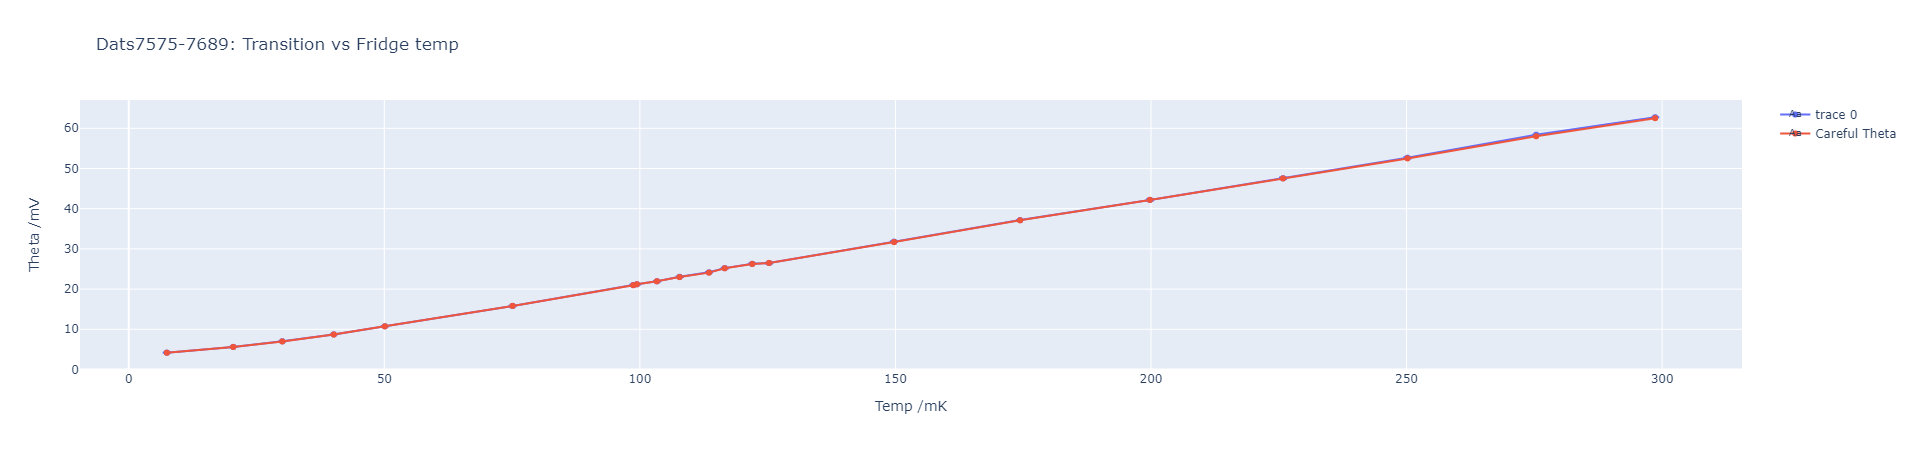

In [25]:
fig = go.Figure()
ds = dats
ddict = {d.Logs.temps.mc: d for d in ds}
ds = [ddict[k] for k in sorted(ddict)]
temps = [dat.Logs.temps.mc*1000 for dat in ds]

thetas, thetastderr = list(), list()
better_thetas = list()
for dat, info in zip(ds, infos):
    if (f := dat.Other.trans_fit) is not None:
        thetas.append(f.best_values.theta)
        thetastderr.append(sem(np.array([f.best_values.theta for f in dat.Transition.all_fits],dtype=np.float32)))
    else:
        thetas.append(0)
        thetastderr.append(0)

    better_thetas.append(info.avg_fit.best_values.theta)
        
thetas = [t if t is not None else -1 for t in thetas]


fig.add_trace(go.Scatter(mode='markers+lines+text', x=temps, y=thetas, error_y=dict(array=thetastderr)))
fig.add_trace(go.Scatter(mode='markers+lines+text', x=temps, y=better_thetas, name='Careful Theta'))
    
fig.update_layout(xaxis_title='Temp /mK', yaxis_title='Theta /mV', title=f'Dats{dats[0].datnum}-{dats[-1].datnum}: Transition vs Fridge temp')
fig

In [21]:
fig.write_html(f'Dats{dats[0].datnum}-{dats[-1].datnum}--Transition vs Fridge temp.html')

In [ ]:
def plot_careful_fit(dat = None, info = None) -> go.Figure:
    if dat is None and info is None:
        raise ValueError
    elif dat is not None and info is not None:
        raise ValueError

    if dat is not None:
        info = calculate_careful_fit(dat)
    else:
        info = info
    
    x = info.param_values
    y = np.array(range(len(x)))
    xa = x[info.accepted_rows]
    ya = y[info.accepted_rows]

    xr = x[info.rejected_rows]
    yr = y[info.rejected_rows]


    fig = go.Figure()
    fig.add_trace(go.Scatter(mode='markers', x=xa, y=ya, name=f'Dat{info.datnum} - Accepted', marker=dict(color='blue'))) 
    fig.add_trace(go.Scatter(mode='markers', x=xr, y=yr, name=f'Dat{info.datnum} - Rejected', marker=dict(color='red'))) 
    fig.update_layout(title = f'Dat{info.datnum}: Avg_fit {info.param} from all data = {getattr(info.original_fit.best_values, info.param):.3f}mV<br>' \
                      f'Avg_fit {info.param} from accepted data = {getattr(info.avg_fit.best_values, info.param):.3f}mV')

    
    return fig

import plotly.express as px

dd = {dat.datnum: dat for dat in dats}
info = calculate_careful_fit(dats[0], param='theta')
fig = plot_careful_fit(info=info)
fig2 = px.line(x=info.x, y=info.avg_data)
fig2.add_trace(go.Scatter(mode='lines', x=info.x, y=info.avg_fit.eval_fit(x=info.x)))
fig.show()
fig2.show()